In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import sys
print(sys.executable)

import math
import pandas as pd
from pandas import Timestamp
import numpy as np
import glob
import os
import datetime as dt
from datetime import datetime
from pprint import pprint
from collections import OrderedDict

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display, HTML
import seaborn as sns

from typing import Optional, Dict, Tuple, List, Sequence
from sklearn.preprocessing import StandardScaler

from tqdm.auto import tqdm
tqdm.pandas()        

pd.set_option('display.max_columns', None)



/usr/bin/python


[main] Found existing base CSV: dfs_training/AAPL_1_base.csv


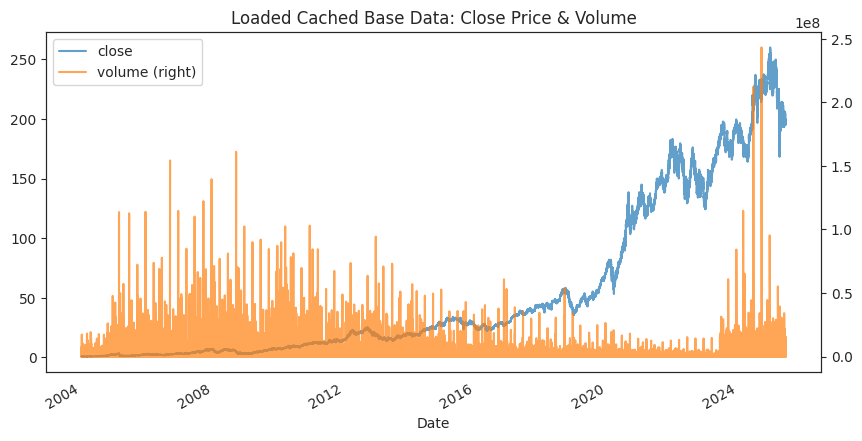

,open,high,low,close,volume,ask,bid
2004-01-02 11:30:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
2004-01-02 11:31:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
2004-01-02 11:32:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
2004-01-02 11:33:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
2004-01-02 11:34:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.680000,196.860000,196.630000,196.815000,385695.0,196.874000,196.756000
2025-06-18 20:57:00,196.810000,196.940000,196.560000,196.675000,460630.0,196.734000,196.616000
2025-06-18 20:58:00,196.675000,196.740000,196.630000,196.670000,525245.0,196.729000,196.611000
2025-06-18 20:59:00,196.680000,196.750000,196.240000,196.240000,2075503.0,196.298900,196.181100


In [2]:
ticker = params.ticker
base_csv = params.base_csv

if os.path.exists(base_csv):
    # -----------------------------------------------------------------
    # 1) Cached file exists → load it, plot it, skip all processing.
    # -----------------------------------------------------------------
    print(f"[main] Found existing base CSV: {base_csv}")
    df = pd.read_csv(base_csv, index_col=0, parse_dates=True)
    plots.plot_close_volume(
        df,
        title="Loaded Cached Base Data: Close Price & Volume"
    )

else:
    # -----------------------------------------------------------------
    # 2) No cached file → do the full split‐adjust and then minute‐grid prep
    # -----------------------------------------------------------------
    print(f"[main] No base CSV found; running process_splits …")
    df_raw = trades.process_splits(
        folder                   = params.stocks_folder,
        ticker                   = ticker,
        bidasktoclose_spread     = params.bidasktoclose_spread
    )

    # Once‐only minute grid build and interpolation
    print(f"[main] Running prepare_interpolate_data …")
    df = trades.prepare_interpolate_data(
        df                    = df_raw,
        regular_start_shifted = params.regular_start_shifted,
        regular_start         = params.regular_start,
        regular_end           = params.regular_end
    )
    
    # Persist to base CSV and return
    df.to_csv(base_csv)
    print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [3]:
# global_ref  = trades.compute_global_ref_profit(df = df)
# global_ref # reference median used to scale the signal

In [4]:
def process_single_day(day_str, buy_threshold): 
    # Processes one calendar day, called by the function 'saveDF_checkDAY'
    print(f"\n=== Processing trading day {day_str} ===")
    day_dt = pd.to_datetime(day_str)
    day_df = df.loc[df.index.normalize() == day_dt].copy()
    if day_df.empty:
        print(" no data; skipping.")
        return
            
    print("\n Running trading pipeline on selected date …")
    result = trades.run_trading_pipeline(day_df, 
                                         col_signal='signal',
                                         col_action='signal_action',
                                         # ref_profit=global_ref,
                                         day_to_check=day_str)
    
    if result is None:
        print(" no trades found; skipping.")
        return

    df_day, trades_day, perf_day = result
    plots.plot_trades(
        df=df_day,
        col_signal1='signal',
        col_signal2=False,
        col_action='signal_action',
        trades=trades_day,
        buy_threshold=buy_threshold,
        performance_stats=perf_day
    )

    print(f"\n=== Performance for {day_dt} ===")
    for k, v in perf_day.items():
        print(f"{k}: {v}")

    return df_day, perf_day


In [5]:
def saveDF_checkDAY(
    df,
    ticker,
    min_prof_thr,
    max_down_prop,
    gain_tightening_factor,
    pre_entry_decay,
    buy_threshold,
    trailing_stop_thresh,
    merging_retracement_thr,
    merging_time_gap_thr
):
    """
    Modes:
      • date_to_check Month ('YYYY-MM')   → process each day, then summary  
      • createCSVsign  → full‐run: pipeline, merge+interpolate w/ progress, save CSV  
    """
    
    keep_cols = [
        "open","high","low","close","volume", "bid","ask", "StrategyEarning","EarningDiff", "signal", "signal_action"
    ]

    print(f"\nMonth mode: processing {params.date_to_check}")

    # collect all days in this month
    dates_days = (
        df.loc[df.index.strftime("%Y-%m") == params.date_to_check]
          .index.normalize()
          .unique()
    )

    performance_list = []
    daily_frames     = []
    
    for date_day in sorted(dates_days.astype(str)):
        res = process_single_day(date_day, buy_threshold)
        if res is None:
            continue

        df_day, perf_day = res
        daily_frames.append(df_day)       # collect the day’s DF
        performance_list.append(perf_day) # collect its stats

    if not daily_frames:
        print("No valid days in this month.")
        return

    # build the month‐DF from exactly those df_day’s
    df_month = pd.concat(daily_frames).sort_index()
    # print monthly performance summary
    plots.aggregate_performance(performance_list, df_month)

    if params.createCSVsign == False:

        return df_month

    else: # if createCSVsign == True:
        
        print(f"\nFull-run mode")
        
        print("\n•Running trading pipeline on full dataset …")
        full_sim_results = trades.run_trading_pipeline( 
            df,
            col_signal='signal',
            col_action='signal_action',
            # ref_profit=global_ref,
            day_to_check=None
        )
    
        print("\n•Merging, concatenating all days, and calculating test performances …")
        daily_frames    = [res[0][keep_cols] for res in full_sim_results.values()]
        df_all          = pd.concat(daily_frames).sort_index()
        performance_all = [res[2] for res in full_sim_results.values()]
        plots.aggregate_performance(performance_all, df_all)
        days_all = df_all.index.normalize().unique()
    
        # prepare the performances summary just for the test days
        cutoff   = int(len(days_all) * (params.train_prop + params.val_prop))
        test_days = days_all[cutoff:][1:]   # to use the same test days as in the model test prediction
        df_test = df_all[ df_all.index.normalize().isin(test_days) ]
        performance_test = [perf
                            for day, (_,_,perf) in full_sim_results.items()
                            if pd.Timestamp(day).normalize() in test_days]
        plots.aggregate_performance(performance_test, df_test)    
    
        print("\n•Saving CSV …")
        sign_csv = params.sign_csv
        df_all.to_csv(sign_csv)
        print(f"Saved to {sign_csv}")
    
        return df_all




Month mode: processing 2005-05

=== Processing trading day 2005-05-02 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


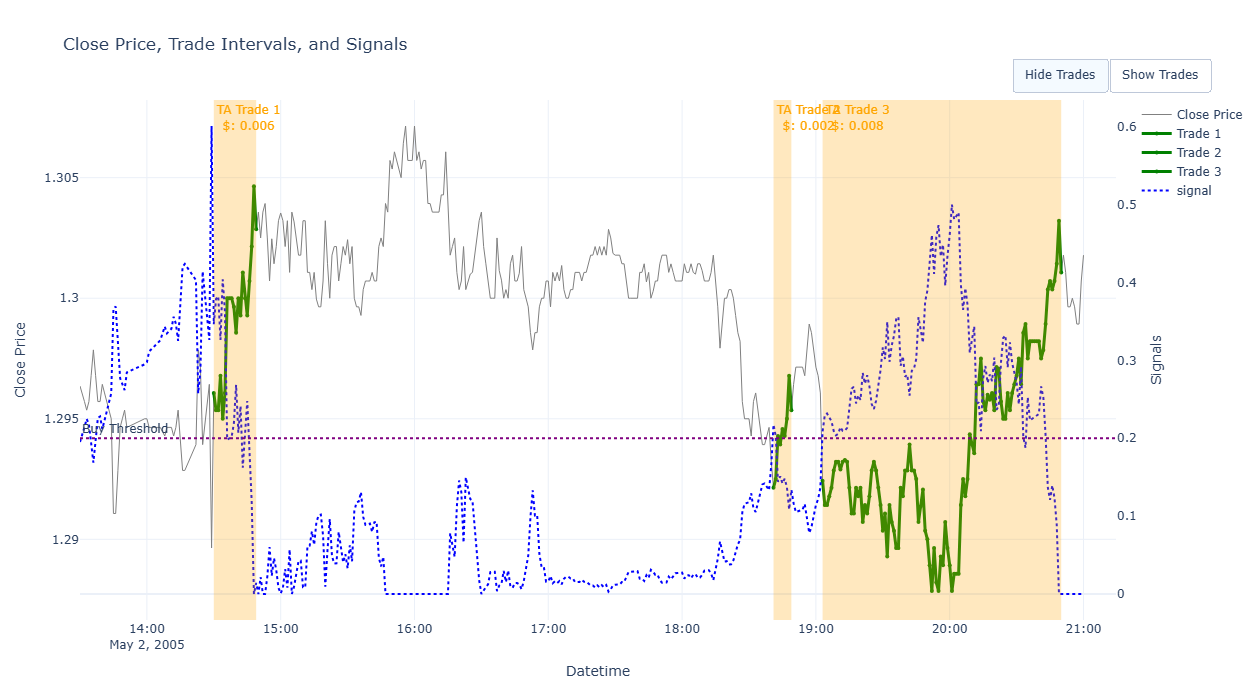


=== Performance for 2005-05-02 00:00:00 ===
Buy & Hold Return ($): 0.005
Strategy Return ($): 0.016
Trades Returns ($): [0.006, 0.002, 0.008]

=== Processing trading day 2005-05-03 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


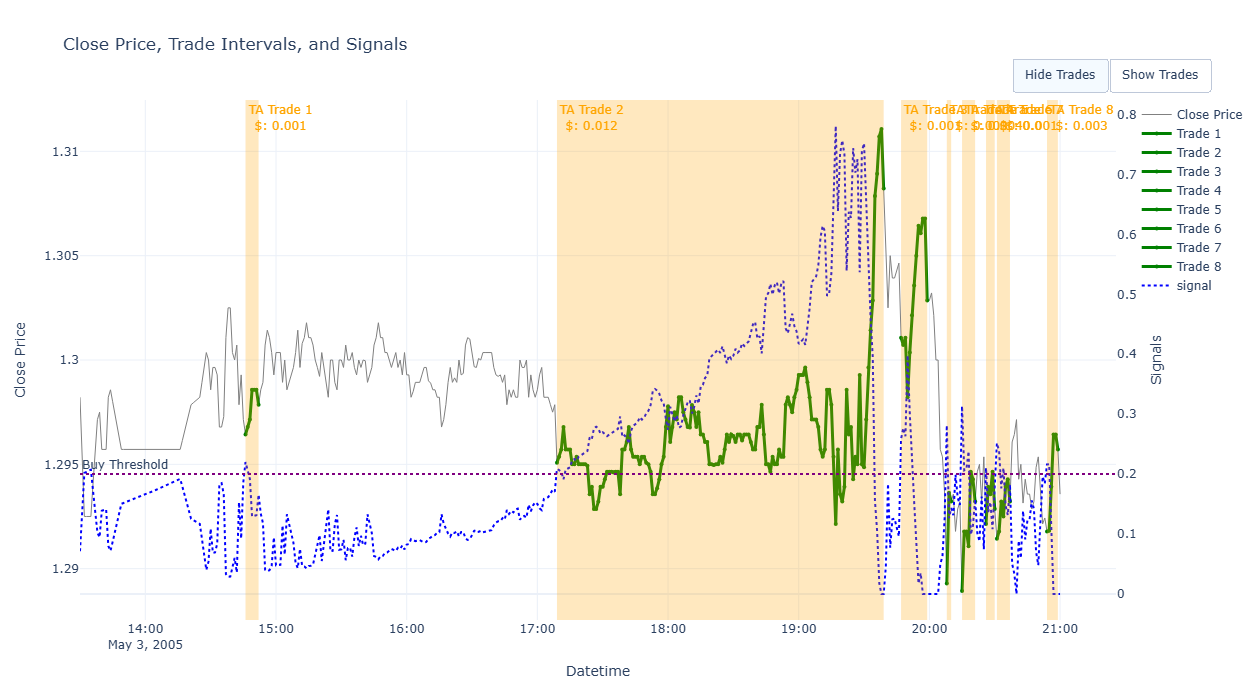


=== Performance for 2005-05-03 00:00:00 ===
Buy & Hold Return ($): -0.006
Strategy Return ($): 0.025
Trades Returns ($): [0.001, 0.012, 0.001, 0.003, 0.004, -0.0, 0.001, 0.003]

=== Processing trading day 2005-05-04 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


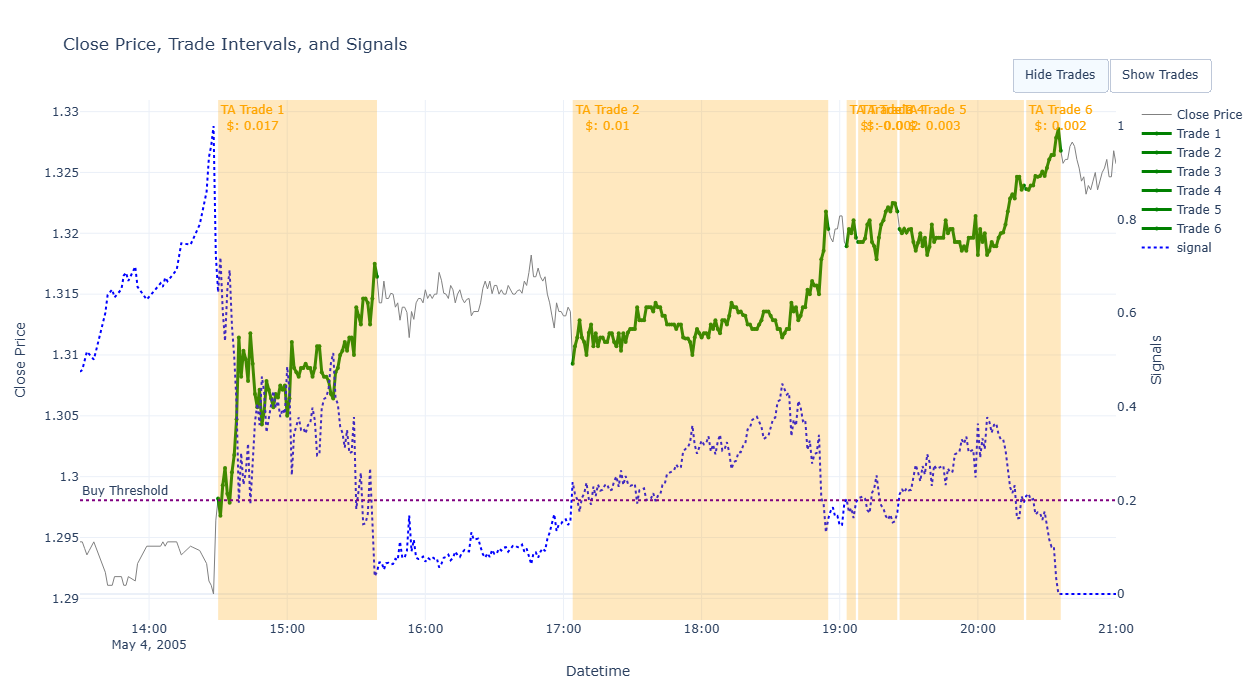


=== Performance for 2005-05-04 00:00:00 ===
Buy & Hold Return ($): 0.027
Strategy Return ($): 0.034
Trades Returns ($): [0.017, 0.01, -0.0, 0.002, 0.003, 0.002]

=== Processing trading day 2005-05-05 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


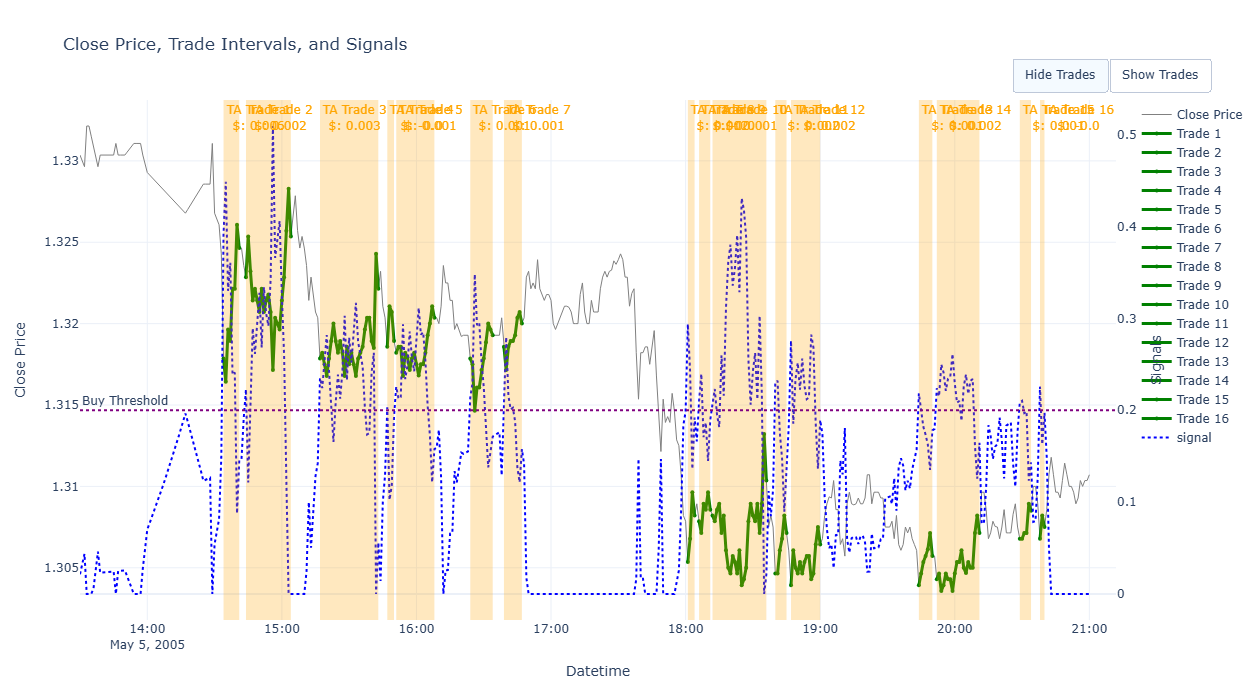


=== Performance for 2005-05-05 00:00:00 ===
Buy & Hold Return ($): -0.017
Strategy Return ($): 0.024
Trades Returns ($): [0.006, 0.002, 0.003, -0.0, 0.001, 0.001, 0.001, 0.002, -0.0, 0.001, 0.002, 0.002, 0.001, 0.002, 0.001, -0.0]

=== Processing trading day 2005-05-06 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


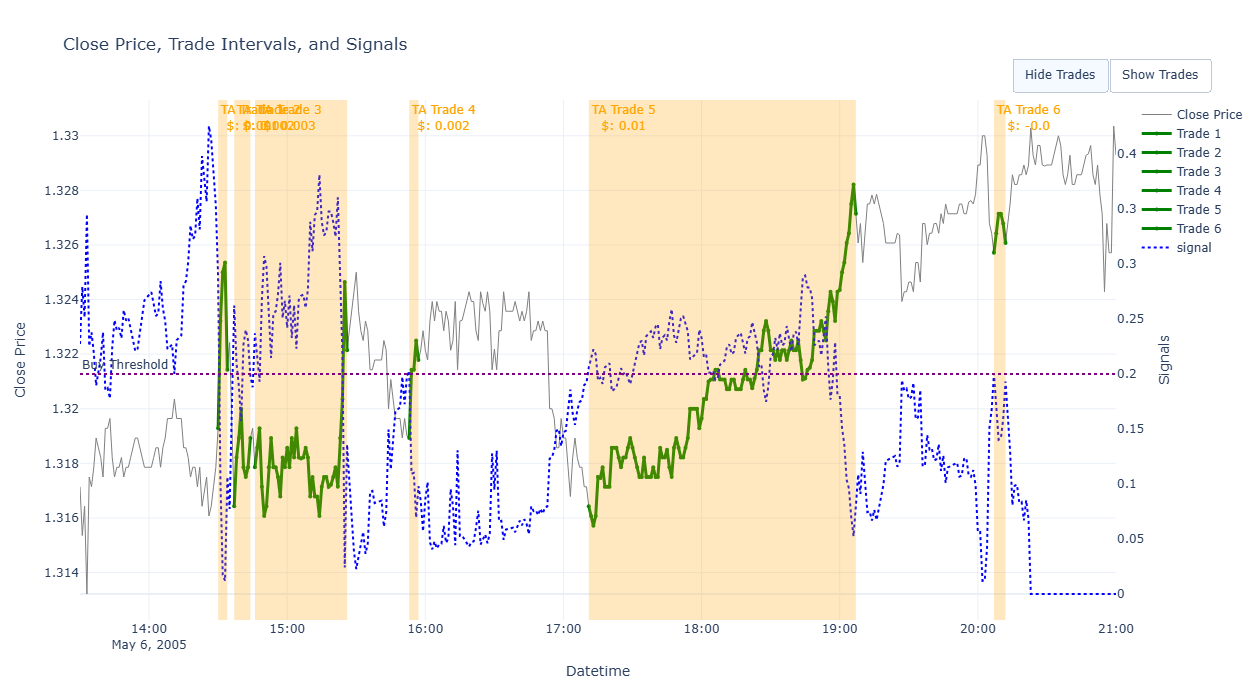


=== Performance for 2005-05-06 00:00:00 ===
Buy & Hold Return ($): 0.009
Strategy Return ($): 0.018
Trades Returns ($): [0.001, 0.002, 0.003, 0.002, 0.01, -0.0]

=== Processing trading day 2005-05-09 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


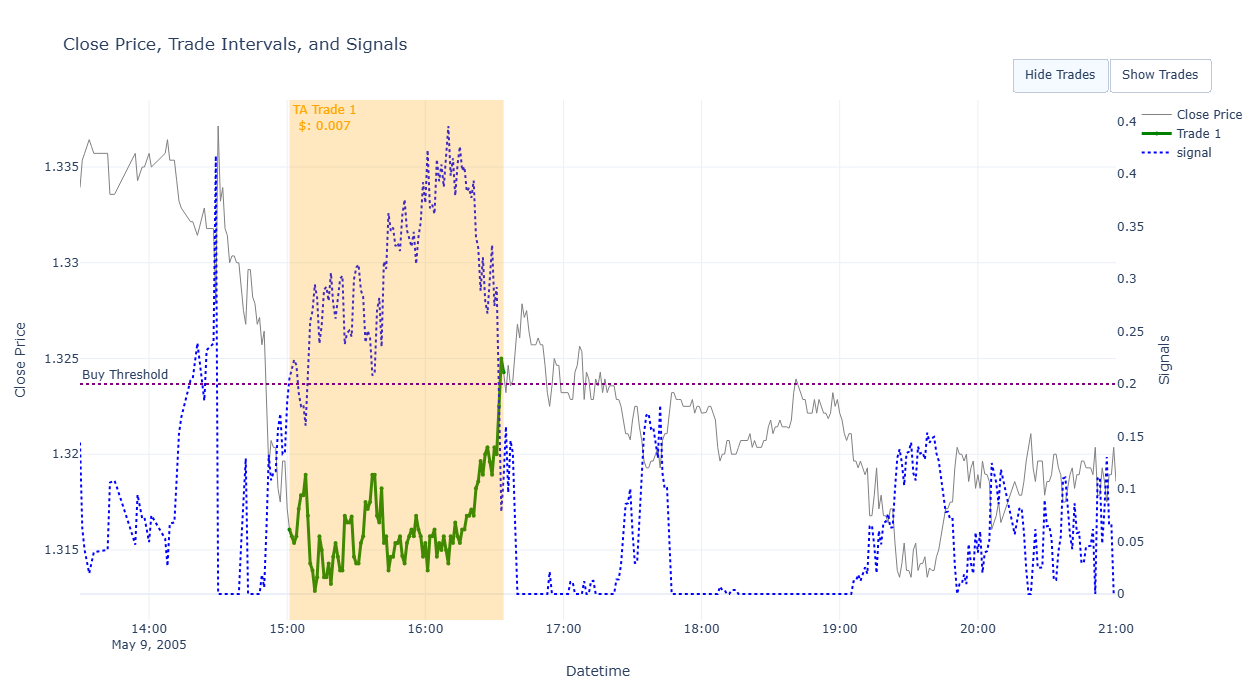


=== Performance for 2005-05-09 00:00:00 ===
Buy & Hold Return ($): -0.019
Strategy Return ($): 0.007
Trades Returns ($): [0.007]

=== Processing trading day 2005-05-10 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



=== Performance for 2005-05-10 00:00:00 ===
Buy & Hold Return ($): -0.013
Strategy Return ($): 0.022
Trades Returns ($): [-0.0, 0.003, 0.002, 0.005, 0.001, 0.003, 0.003, 0.004]

=== Processing trading day 2005-05-11 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



=== Performance for 2005-05-11 00:00:00 ===
Buy & Hold Return ($): 0.012
Strategy Return ($): 0.047
Trades Returns ($): [0.002, 0.002, -0.0, 0.001, 0.042]

=== Processing trading day 2005-05-12 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



=== Performance for 2005-05-12 00:00:00 ===
Buy & Hold Return ($): -0.047
Strategy Return ($): 0.021
Trades Returns ($): [0.004, 0.002, 0.002, 0.004, 0.001, -0.0, 0.001, 0.003, 0.0, 0.002, 0.001]

=== Processing trading day 2005-05-13 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



=== Performance for 2005-05-13 00:00:00 ===
Buy & Hold Return ($): 0.016
Strategy Return ($): 0.045
Trades Returns ($): [0.03, 0.001, 0.001, 0.003, 0.003, -0.0, 0.004, 0.001, 0.003]

=== Processing trading day 2005-05-16 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



=== Performance for 2005-05-16 00:00:00 ===
Buy & Hold Return ($): 0.027
Strategy Return ($): 0.039
Trades Returns ($): [0.024, 0.008, 0.001, 0.001, 0.005]

=== Processing trading day 2005-05-17 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



=== Performance for 2005-05-17 00:00:00 ===
Buy & Hold Return ($): 0.008
Strategy Return ($): 0.029
Trades Returns ($): [0.001, -0.001, 0.0, 0.025, 0.003]

=== Processing trading day 2005-05-18 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



=== Performance for 2005-05-18 00:00:00 ===
Buy & Hold Return ($): 0.012
Strategy Return ($): 0.03
Trades Returns ($): [0.026, -0.0, 0.001, 0.002]

=== Processing trading day 2005-05-19 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



=== Performance for 2005-05-19 00:00:00 ===
Buy & Hold Return ($): 0.054
Strategy Return ($): 0.064
Trades Returns ($): [0.038, 0.026]

=== Processing trading day 2005-05-20 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



=== Performance for 2005-05-20 00:00:00 ===
Buy & Hold Return ($): 0.009
Strategy Return ($): 0.017
Trades Returns ($): [0.005, 0.001, 0.005, 0.003, 0.001, 0.001, 0.0]

=== Processing trading day 2005-05-23 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



=== Performance for 2005-05-23 00:00:00 ===
Buy & Hold Return ($): 0.055
Strategy Return ($): 0.062
Trades Returns ($): [0.052, 0.005, 0.001, 0.002, 0.001, -0.0, 0.002]

=== Processing trading day 2005-05-24 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



=== Performance for 2005-05-24 00:00:00 ===
Buy & Hold Return ($): 0.017
Strategy Return ($): 0.04
Trades Returns ($): [0.02, 0.004, 0.001, 0.001, 0.002, 0.003, 0.003, 0.001, 0.005]

=== Processing trading day 2005-05-25 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



=== Performance for 2005-05-25 00:00:00 ===
Buy & Hold Return ($): 0.008
Strategy Return ($): 0.034
Trades Returns ($): [0.01, 0.002, 0.003, 0.01, 0.005, 0.002, 0.002, 0.001]

=== Processing trading day 2005-05-26 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



=== Performance for 2005-05-26 00:00:00 ===
Buy & Hold Return ($): 0.017
Strategy Return ($): 0.024
Trades Returns ($): [0.021, -0.0, 0.003, 0.0]

=== Processing trading day 2005-05-27 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



=== Performance for 2005-05-27 00:00:00 ===
Buy & Hold Return ($): -0.007
Strategy Return ($): 0.014
Trades Returns ($): [0.001, 0.0, 0.001, 0.003, 0.0, 0.004, 0.004]

=== Processing trading day 2005-05-31 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



=== Performance for 2005-05-31 00:00:00 ===
Buy & Hold Return ($): -0.035
Strategy Return ($): 0.007
Trades Returns ($): [0.002, 0.001, 0.001, 0.004]

Overall Summary (2005-05-02 = 1.2965 → 2005-05-31 = 1.4196)

One-time buy&hold gain: 0.123
Buy & Hold – each day ($): 0.132
Strategy Return ($): 0.619
Trades Count: 135
Strategy return per trade: 0.005
Num. trading days: 21
Strategy return per trading day: 0.029


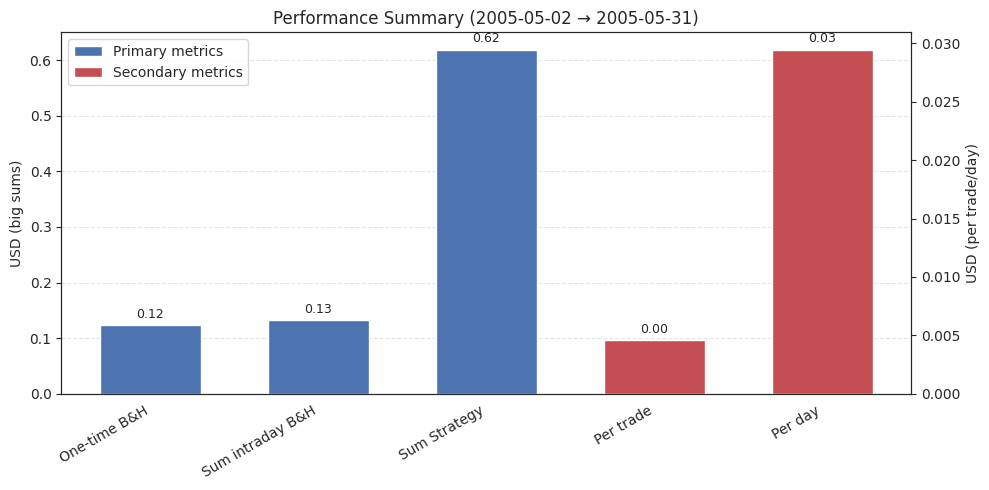


Full-run mode

•Running trading pipeline on full dataset …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …

•Merging, concatenating all days, and calculating test performances …

Overall Summary (2004-01-02 = 0.7727 → 2025-06-18 = 196.4810)

One-time buy&hold gain: 195.708
Buy & Hold – each day ($): -118.397
Strategy Return ($): 4122.554
Trades Count: 29497
Strategy return per trade: 0.140
Num. trading days: 5377
Strategy return per trading day: 0.767


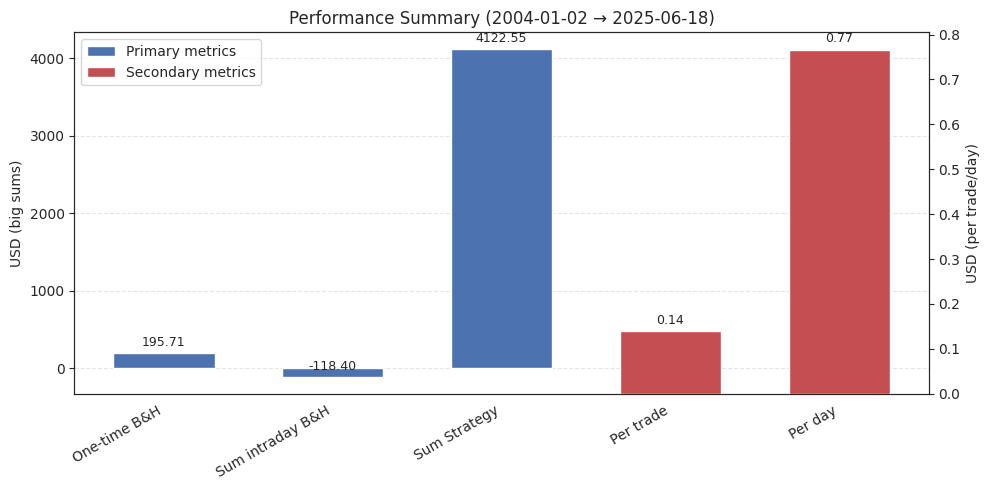


Overall Summary (2022-04-01 = 174.5123 → 2025-06-18 = 196.4810)

One-time buy&hold gain: 21.969
Buy & Hold – each day ($): -55.373
Strategy Return ($): 2076.158
Trades Count: 4107
Strategy return per trade: 0.506
Num. trading days: 806
Strategy return per trading day: 2.576


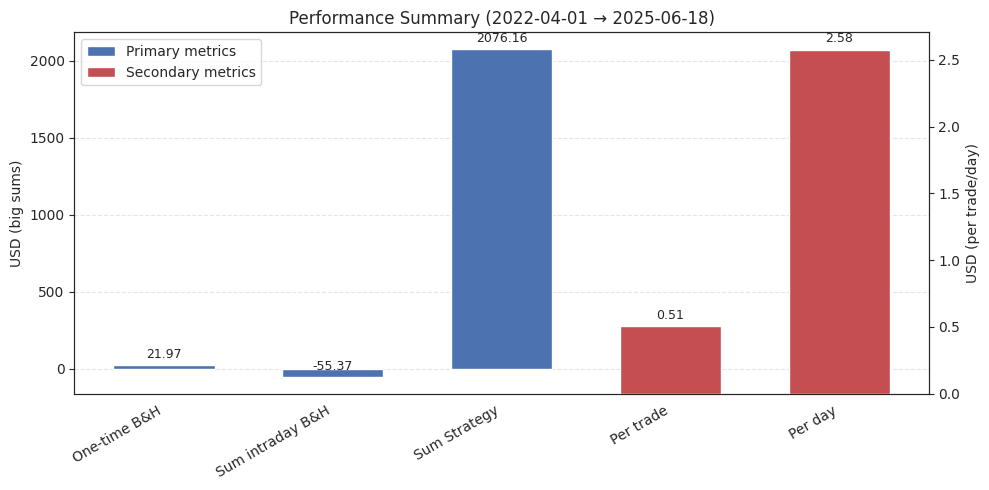


•Saving CSV …
Saved to dfs_training/AAPL_2_sign.csv


,open,high,low,close,volume,bid,ask,StrategyEarning,EarningDiff,signal,signal_action
2004-01-02 12:30:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764057,0.764514,0.000,0.000,0.400756,0
2004-01-02 12:31:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764057,0.764514,0.000,0.000,0.404379,0
2004-01-02 12:32:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764057,0.764514,0.000,0.000,0.408035,0
2004-01-02 12:33:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764057,0.764514,0.000,0.000,0.411724,0
2004-01-02 12:34:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764057,0.764514,0.000,0.000,0.415446,0
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.680000,196.860000,196.630000,196.815000,385695.0,196.756000,196.874000,2.232,1.455,0.000000,0
2025-06-18 20:57:00,196.810000,196.940000,196.560000,196.675000,460630.0,196.616000,196.734000,2.232,1.595,0.000000,0
2025-06-18 20:58:00,196.675000,196.740000,196.630000,196.670000,525245.0,196.611000,196.729000,2.232,1.600,0.000000,0
2025-06-18 20:59:00,196.680000,196.750000,196.240000,196.240000,2075503.0,196.181100,196.298900,2.232,2.030,0.000000,0


In [6]:
df_fin = saveDF_checkDAY(
                        df=df,
                        ticker=params.ticker,
                        min_prof_thr=params.min_prof_thr_tick, 
                        max_down_prop=params.max_down_prop_tick, 
                        gain_tightening_factor=params.gain_tightening_factor_tick,
                        pre_entry_decay=params.pre_entry_decay_tick, 
                        buy_threshold=params.buy_threshold_tick, 
                        trailing_stop_thresh=params.trailing_stop_thresh_tick,
                        merging_retracement_thr=params.merging_retracement_thr_tick, 
                        merging_time_gap_thr=params.merging_time_gap_thr_tick
                        )

df_fin


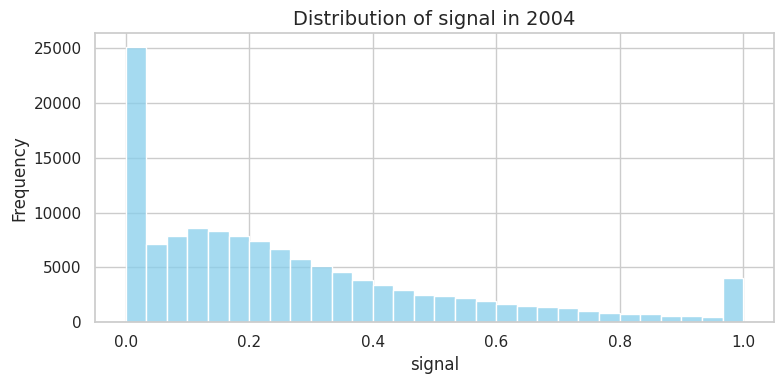

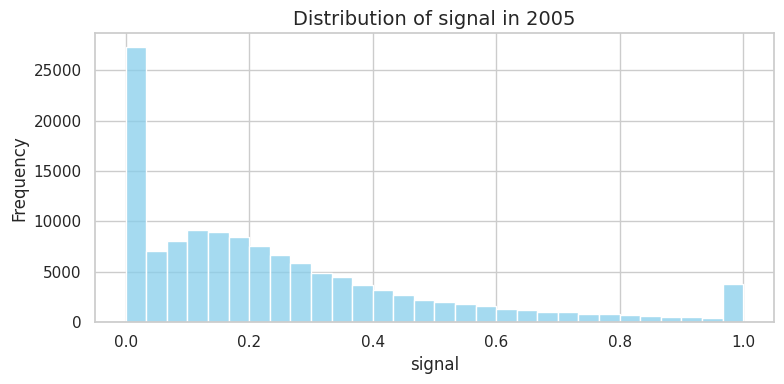

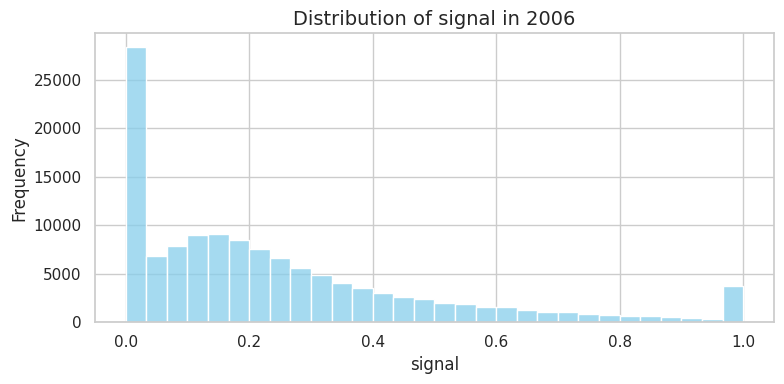

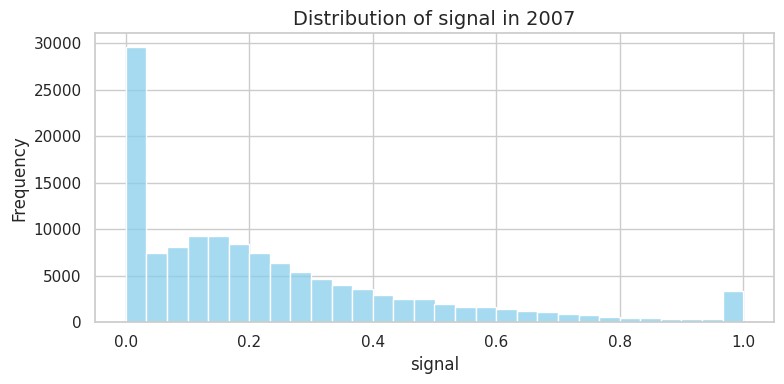

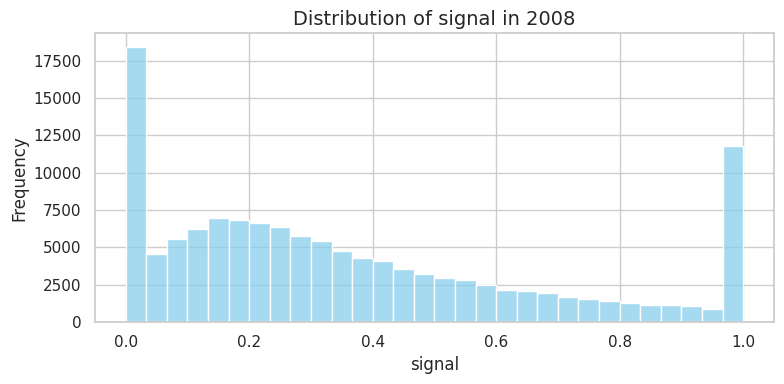

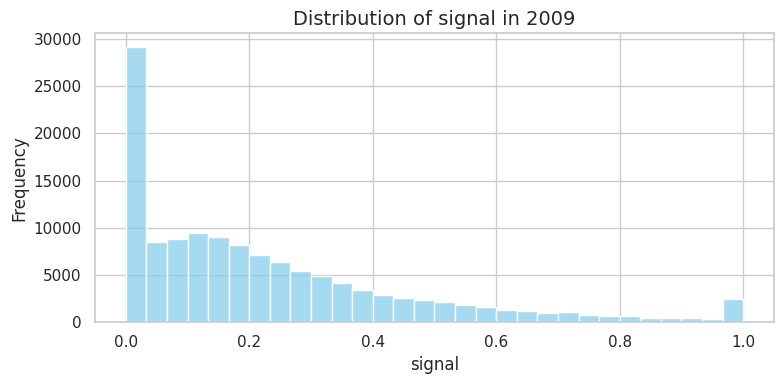

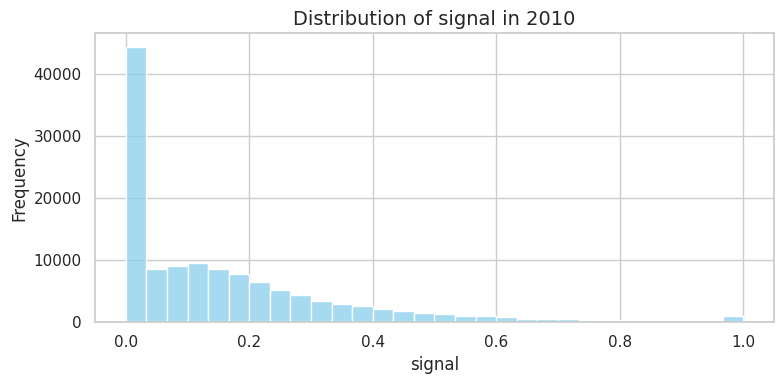

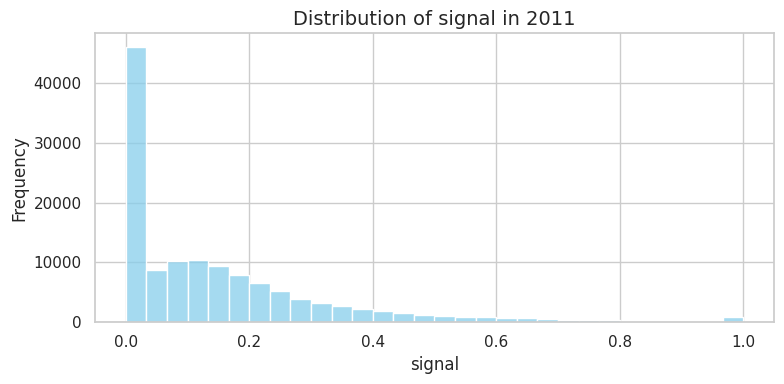

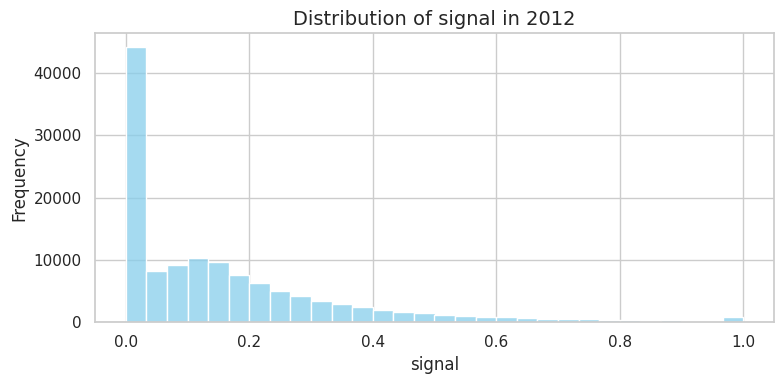

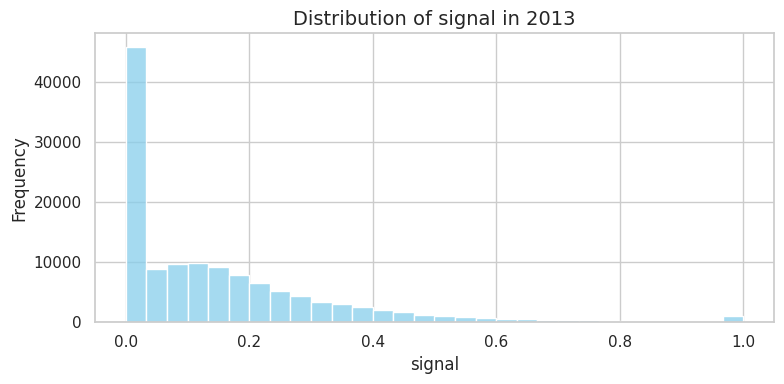

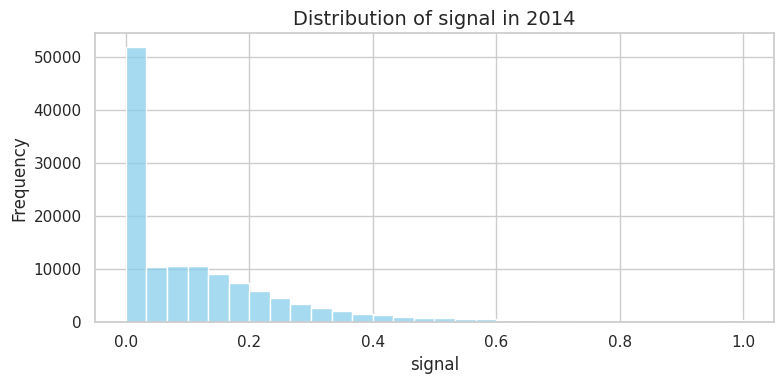

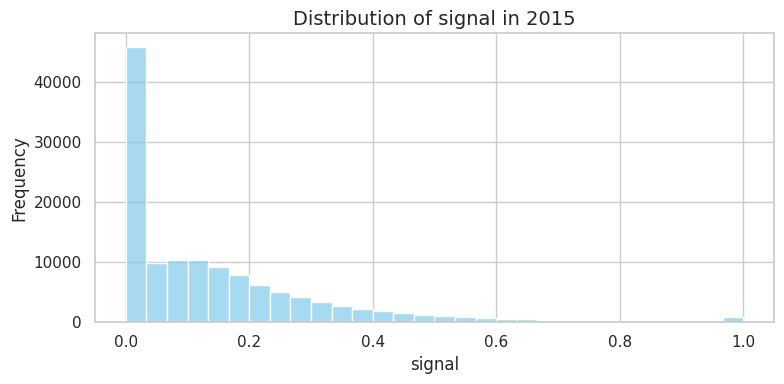

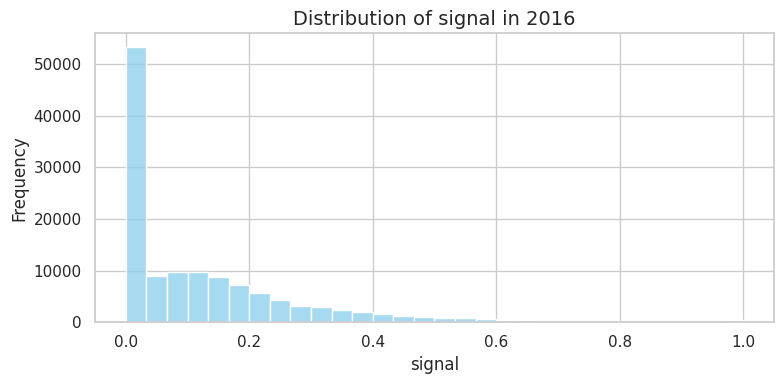

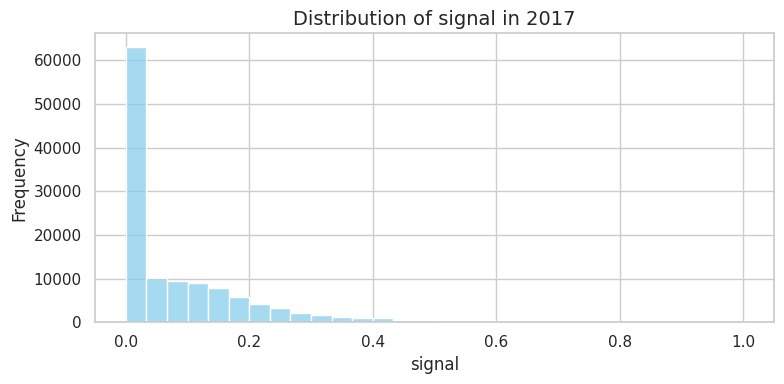

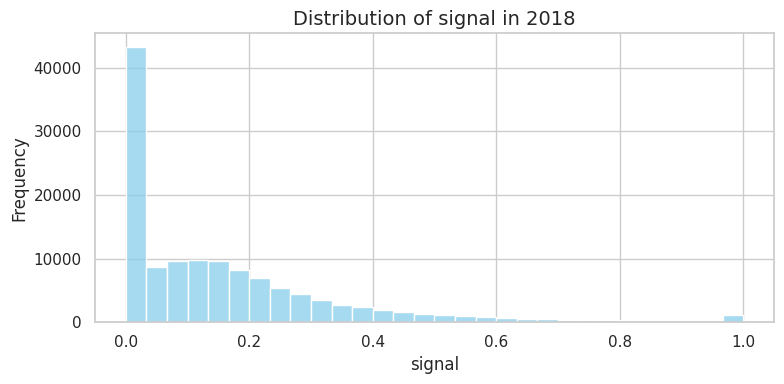

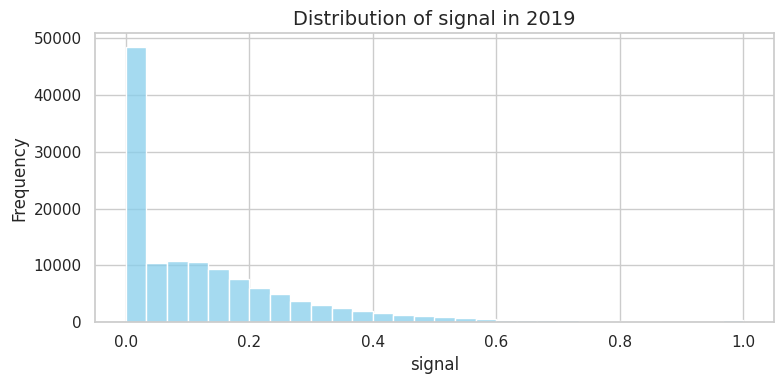

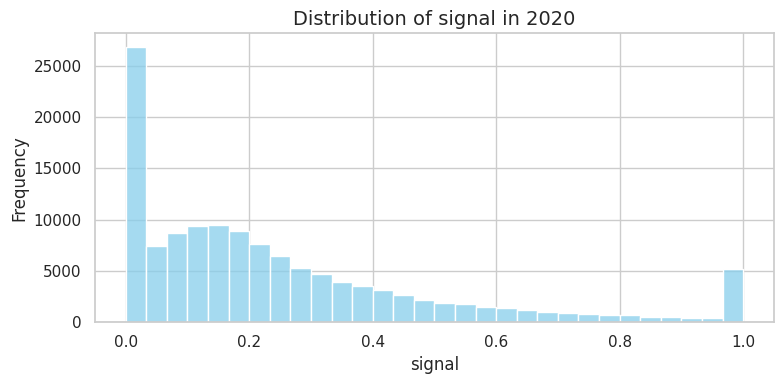

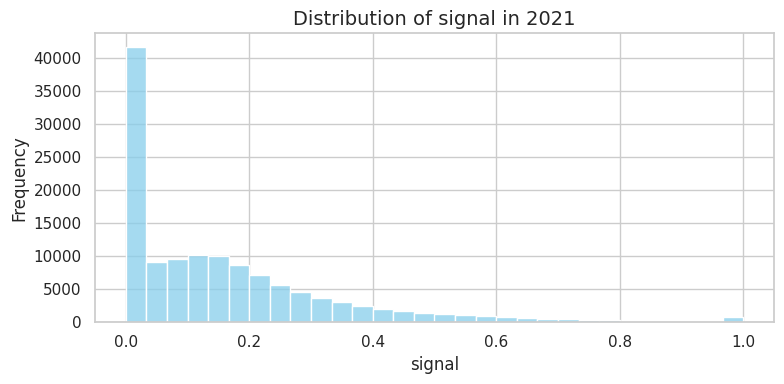

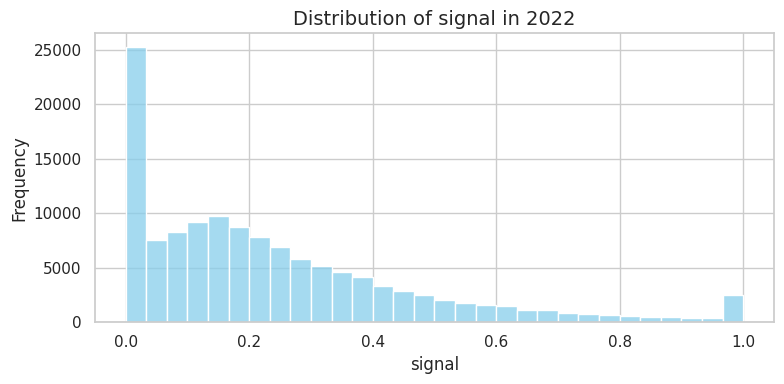

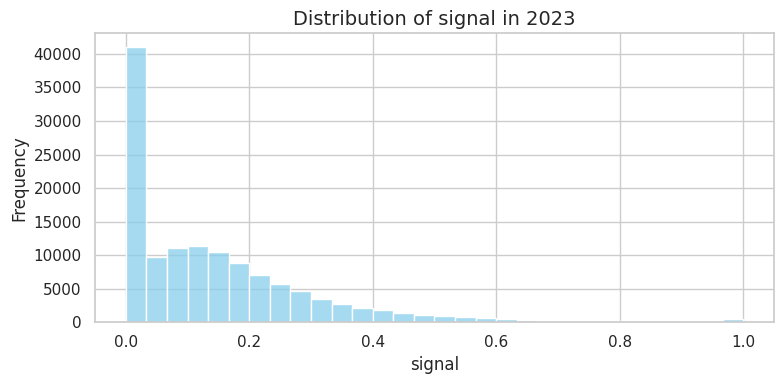

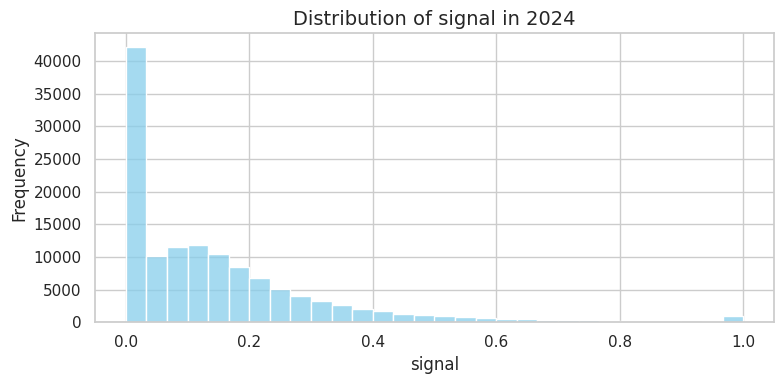

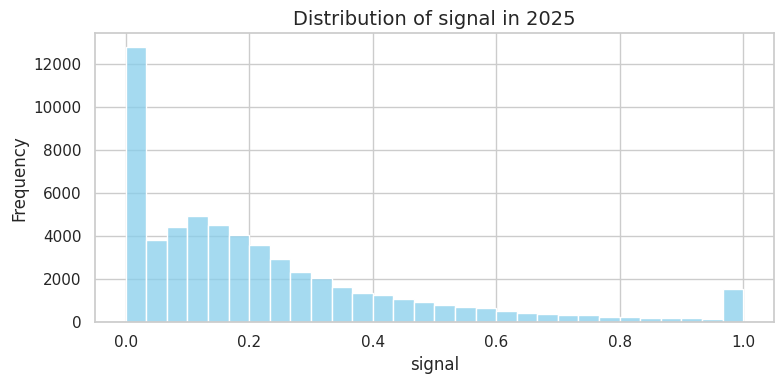

,signal_min,signal_max,signal_mean,signal_median,close_return
2004-01,0.0,1.000000,0.271055,0.205514,0.170916
2004-02,0.0,1.000000,0.235414,0.173668,0.105893
2004-03,0.0,1.000000,0.274158,0.213163,0.196335
2004-04,0.0,1.000000,0.236535,0.174624,0.156863
2004-05,0.0,1.000000,0.299305,0.228823,0.127743
...,...,...,...,...,...
2025-02,0.0,1.000000,0.206723,0.135317,0.105627
2025-03,0.0,1.000000,0.236557,0.184527,0.168574
2025-04,0.0,1.000000,0.365635,0.274779,0.338585
2025-05,0.0,1.000000,0.183168,0.135974,0.109857


In [7]:
# Group by month
period = df_fin.index.to_period('M')

# Monthly stats for signal
signal_stats = df_fin.groupby(period)['signal'].agg(
    signal_min='min',
    signal_max='max',
    signal_mean='mean',
    signal_median='median'
)

# Monthly close return: (max - min) / min
close_return = df_fin.groupby(period)['close'].agg(
    close_return=lambda x: np.nan if x.min() == 0 else (x.max() - x.min()) / x.min()
)

# Combine into one DataFrame
monthly_stats = signal_stats.join(close_return)


# --------------------------------------------------
# Now plot histograms of signal for each year
# --------------------------------------------------

sns.set(style="whitegrid")
unique_years = sorted(df_fin.index.year.unique())

for y in unique_years:
    subset = df_fin[df_fin.index.year == y]['signal']
    
    plt.figure(figsize=(8, 4))
    sns.histplot(subset, bins=30, kde=False, color="skyblue")
    plt.title(f"Distribution of signal in {y}", fontsize=14)
    plt.xlabel("signal", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.tight_layout()
    plt.show()

monthly_stats
